## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 3 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 12
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.734000027179718
epoch 2: valid acc = 0.7749999761581421
epoch 3: valid acc = 0.8090000152587891
epoch 4: valid acc = 0.8370000123977661
epoch 5: valid acc = 0.843999981880188
epoch 6: valid acc = 0.8500000238418579
epoch 7: valid acc = 0.8519999980926514
epoch 8: valid acc = 0.8579999804496765
epoch 9: valid acc = 0.8650000095367432
epoch 10: valid acc = 0.8669999837875366
epoch 11: valid acc = 0.8659999966621399
epoch 12: valid acc = 0.8669999837875366
test acc = 0.8561999797821045


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

<span style="color:red"><strong>Solution</strong></span>:

In [10]:
hidden_dim1 = 200
hidden_dim2=300
hidden_dim3=400
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim1).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim1,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim1, hidden_dim2).astype('float32'))
        self.b2 = tf.Variable(np.zeros((hidden_dim2,)).astype('float32'))
        self.W3 = tf.Variable(1e-2*np.random.rand(hidden_dim2, hidden_dim3).astype('float32'))
        self.b3 = tf.Variable(np.zeros((hidden_dim3,)).astype('float32'))
        self.W4 = tf.Variable(1e-2*np.random.rand(hidden_dim3, 20).astype('float32'))
        self.b4 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        h2 = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
        h3 = tf.nn.relu(tf.matmul(h2, self.W3) + self.b3)
        out = tf.matmul(h3, self.W4) + self.b4
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)+ tf.nn.l2_loss(model.W3)+ tf.nn.l2_loss(model.W4)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2,model.W3, model.b3,model.W4, model.b4])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W4, model.b4]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.11599999666213989
epoch 2: valid acc = 0.15199999511241913
epoch 3: valid acc = 0.1679999977350235
epoch 4: valid acc = 0.17900000512599945
epoch 5: valid acc = 0.18199999630451202
epoch 6: valid acc = 0.18700000643730164
epoch 7: valid acc = 0.1889999955892563
epoch 8: valid acc = 0.1899999976158142
epoch 9: valid acc = 0.19300000369548798
epoch 10: valid acc = 0.19300000369548798
epoch 11: valid acc = 0.20100000500679016
epoch 12: valid acc = 0.20800000429153442
epoch 13: valid acc = 0.20999999344348907
epoch 14: valid acc = 0.2800000011920929
epoch 15: valid acc = 0.3009999990463257
test acc = 0.2883000075817108


### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

<span style="color:red"><strong>SOLUTION</strong></span>:

In [11]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential

# END of your code
#############################################################
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])




#############################################################
# TODO: compile the model, set optimizer and loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# END of your code
#############################################################



#############################################################
# TODO: train the model with our own dataset
model.fit(
    X_train,
    y_train,
    epochs=12,
    batch_size=500,  
    
)
# END of your code
#############################################################

Epoch 1/12
98/98 [==============================] - 0s 2ms/step - loss: 30.8026 - sparse_categorical_accuracy: 0.6601
Epoch 2/12
98/98 [==============================] - 0s 2ms/step - loss: 5.6906 - sparse_categorical_accuracy: 0.8275
Epoch 3/12
98/98 [==============================] - 0s 2ms/step - loss: 3.9908 - sparse_categorical_accuracy: 0.8439
Epoch 4/12
98/98 [==============================] - 0s 2ms/step - loss: 3.3025 - sparse_categorical_accuracy: 0.8567
Epoch 5/12
98/98 [==============================] - 0s 2ms/step - loss: 2.3695 - sparse_categorical_accuracy: 0.8708
Epoch 6/12
98/98 [==============================] - 0s 2ms/step - loss: 1.8950 - sparse_categorical_accuracy: 0.8805
Epoch 7/12
98/98 [==============================] - 0s 2ms/step - loss: 1.5790 - sparse_categorical_accuracy: 0.8918
Epoch 8/12
98/98 [==============================] - 0s 2ms/step - loss: 1.2918 - sparse_categorical_accuracy: 0.8965
Epoch 9/12
98/98 [==============================] - 0s 2ms/step

## Part 2: t-SNE (optional, bonus +5 points)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [3]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [4]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [5]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.971133598866312
The 100 th loop cost: 11.51953018279483, computation time: 1.7321224212646484
The 200 th loop cost: 0.5050460978403013, computation time: 3.428363084793091
The 300 th loop cost: 0.47556467068586167, computation time: 5.121638536453247
The 400 th loop cost: 0.47079389944277894, computation time: 6.841261386871338
The 500 th loop cost: 0.4697647230509028, computation time: 8.677821636199951
The 600 th loop cost: 0.46939855062378955, computation time: 10.30426812171936
The 700 th loop cost: 0.4692376425400117, computation time: 11.984068632125854
The 800 th loop cost: 0.4691587520211009, computation time: 13.8572416305542
The 900 th loop cost: 0.46911746090447515, computation time: 15.538753509521484
The 1000 th loop cost: 0.4690949507887779, computation time: 17.396178483963013
it takes 18.033926010131836 seconds


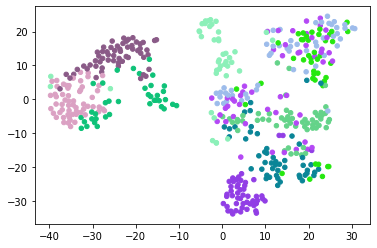

In [6]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [7]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.804, new learning rate = 0.00095
epoch 2: valid acc = 0.839, new learning rate = 0.0009025
epoch 3: valid acc = 0.848, new learning rate = 0.000857375
epoch 4: valid acc = 0.861, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.873, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.874, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.865, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.888, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.882, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.892, new learning rate = 0.0005987369392383785
test acc: 0.8659


0.8659

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [9]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then 
# apply softmax to obtain output of the MLP model.
#############################################################################


X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 20)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.12614006781532364
The 100 th loop cost: 8.17700593122974, computation time: 1.6993343830108643
The 200 th loop cost: 0.2042564956624149, computation time: 3.2240827083587646
The 300 th loop cost: 0.17405597944092993, computation time: 4.781846284866333
The 400 th loop cost: 0.16359276020143101, computation time: 6.468770980834961
The 500 th loop cost: 0.15922494730484948, computation time: 8.128195524215698
The 600 th loop cost: 0.15679799038921277, computation time: 9.759127378463745
The 700 th loop cost: 0.15524263596285323, computation time: 11.633358716964722
The 800 th loop cost: 0.15415483287485957, computation time: 13.472506999969482
The 900 th loop cost: 0.1533248787193085, computation time: 15.373136281967163
The 1000 th loop cost: 0.15268703191479388, computation time: 17.24289870262146
it takes 17.950056552886963 seconds


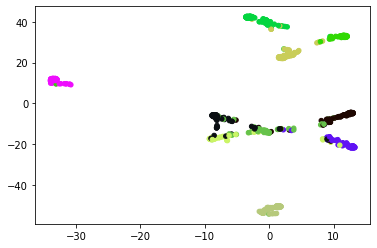

In [10]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data
#############################################################################
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [15]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 20)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=40.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.22586012128143912
The 100 th loop cost: 7.557185422455803, computation time: 1.5864310264587402
The 200 th loop cost: 0.1743548809913123, computation time: 3.1196513175964355
The 300 th loop cost: 0.1545565034349207, computation time: 4.71091103553772
The 400 th loop cost: 0.14871021713627572, computation time: 6.378642559051514
The 500 th loop cost: 0.14648703892248277, computation time: 8.031402111053467
The 600 th loop cost: 0.14526559399368666, computation time: 9.598613500595093
The 700 th loop cost: 0.14442355599160428, computation time: 11.311824083328247
The 800 th loop cost: 0.14381351963791508, computation time: 12.90714955329895
The 900 th loop cost: 0.1433460987443273, computation time: 14.58759069442749
The 1000 th loop cost: 0.1429696538787254, computation time: 16.348867416381836
it takes 16.9728946685791 seconds


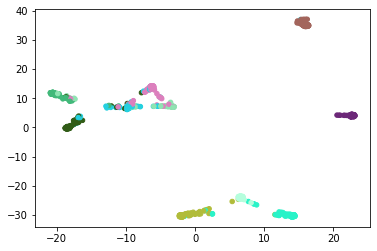

In [16]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################